In [231]:
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast 
from sklearn.inspection import permutation_importance
import geopy.distance as dist

**We define functions to clean the data**

In [233]:
def getKilometersFromCenter(data, city):
    kilometers = np.zeros(data.shape[0])
    if city == 'copenhagen':
        center =  [55.6761, 12.5683]
    elif city == 'stockholm':
        center =  [59.3293, 18.0686]
    elif city == 'london':
        center = [51.5074, -0.1272]
    else:
        center = [52.5373, 13.3603]
    for i in range(data.shape[0]):
        # data[i, 0] = (data[i, 0]- center[0])*111
        # data[i, 1] = (data[i, 1] - center[1])*111
        # kilometers[i] = np.linalg.norm(data[i, 0]-data[i, 1])
        kilometers[i] = dist.geodesic(data[i], center).km
        if(data[i, 0] <  center[0]): 
            data[i, 0] = -dist.geodesic((data[i, 0], center[1]), center).km
        else: 
            data[i, 0] = dist.geodesic((data[i, 0], center[1]), center).km
        if(data[i, 1] <  center[1]):
            data[i, 1] = -dist.geodesic((center[0], data[i, 1]), center).km
        else:
            data[i, 1] = dist.geodesic((center[0], data[i, 1]), center).km
    return kilometers, data, center

In [234]:
def string_features_to_num(array):
    dictOfWords = { i : np.unique(array)[i] for i in range(0, len(np.unique(array)) ) }
    dictOfWords = {v: k for k, v in dictOfWords.items()}
    
    values = np.zeros(len(array))
    for i in range(len(array)):
        values[i] = dictOfWords.get(array[i])
        
    return values, dictOfWords

In [235]:
def selectPropertyType(type, X, y):
    xlist = []
    ylist = []
    for i in range(X.shape[0]):
        if(X[i,-5] == type):
            xlist.append(X[i,:])
            ylist.append(y[i])
    return np.array(xlist), np.array(ylist)

In [236]:
def oneHotEncodingPropertyType(type, X):
    isType = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        if(X[i,0] == type):
            isType[i] = 1.0
    return isType

In [237]:
def plotPredVsReal(yreal, ypred, limit):
    plt.scatter(yreal, ypred, label="pred vs true")
    plt.plot(yreal, yreal, label="y=x", c='red')
    plt.xlabel("y-real")
    plt.ylabel("y-pred")
    plt.xlim((0,limit))
    plt.ylim((0,limit))
    plt.legend()
    plt.show

In [238]:
def plotFeatureVsPrice(feature, price, featureName):
    plt.scatter(feature, price)
    plt.ylabel("price")
    plt.xlabel(featureName)
    plt.show()

In [239]:
def host_Since_fix(X):
    yearsSince = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        yearsSince[i] = 2022 - int(X[i].split('-')[0])
    return yearsSince

In [240]:
from sklearn.inspection import permutation_importance
def plot_feature_importance(best_model, X, y):
    permut = permutation_importance(best_model, X_val, y_val, scoring='r2')
    importance = permut.importances_mean

    # for i,v in enumerate(importance):
    #     print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar(range(len(importance)), importance)
    plt.show()

In [242]:
def plotCity(longAndLat, y):
    heatmapColors = np.clip(y, 0, 800)
    indexes = np.argsort(y)
    # c=scaler.fit_transform(y.reshape(-1,1))
    plt.scatter(longAndLat[indexes,1], longAndLat[indexes,0], c=heatmapColors[indexes], cmap=mpl.colormaps['hot'])
    plt.colorbar()
    plt.scatter(0, 0, label='center')
    plt.legend()
    plt.show()


In [244]:
def amenitiesOneHot(X, amenityName):
    amenities = []
    for i in range(X.shape[0]):
        amenities.append(ast.literal_eval(X[i,-1]))

    amenity = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        for j in range(len(amenities[i])):
            if(amenities[i][j]==amenityName):
                amenity[i] = 1
    return amenity

In [246]:
def cleanBathroomFeature(X, y, featureNum):
    bathroomErr = []
    for i in range(X.shape[0]):
        try:
            X[i,featureNum] = float(X[i,featureNum].split()[0])
        except ValueError:
            bathroomErr.append(i)
    bathroomErr = np.array(bathroomErr)
    X = np.delete(X, bathroomErr, axis=0)
    y = np.delete(y, bathroomErr)
    return X, y

In [247]:
def cleanCurrency(y, city):
    exchange =1
    if city=='copenhagen': exchange = 0.1579
    elif city=='stockholm': exchange = 0.088507
    elif city=='london': exchange = 1.1594
    else: exchange = 1.0151

    for i in range(len(y)):
        y[i] = float(re.sub(",", "", (y[i][1:])))*exchange
    return y

In [248]:
def getCityData(city):
    data = pd.read_csv(('listings_' + city + '.csv.gz'), compression='gzip')
    data = data[['accommodates','bathrooms_text','bedrooms', 'beds', 'host_since', 'review_scores_rating','review_scores_location','review_scores_value','review_scores_cleanliness','reviews_per_month','number_of_reviews','calculated_host_listings_count','minimum_nights','availability_90','property_type','room_type','amenities','latitude','longitude','price']]
    data = data.dropna()

    datanp = np.array(data)
    X = datanp[:,:-1]
    y = datanp[:,-1]

    X, y = cleanBathroomFeature(X, y, 1)
    
    y = cleanCurrency(y, city)

    X[:,-5], propertytype_dict = string_features_to_num(X[:, -5])
    X[:,-4], roomtype_dict = string_features_to_num(X[:, -4])

    # print(propertytype_dict)
    #print(list(enumerate(np.bincount(np.array(X[:, -5],dtype='int64')))))
    # X, y = selectPropertyType(propertytype_dict.get('Entire rental unit'), X, y)
    
    latitudeAndLongitude = X[:,-2:]
    kilometers, longAndLat, center = getKilometersFromCenter(latitudeAndLongitude, city)
    X = X[:,:X.shape[1]-2]

    onehotSource = X[:,-3:]
    X = X[:,:X.shape[1]-3]

    isType = oneHotEncodingPropertyType(propertytype_dict.get('Entire rental unit'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))
    isType = oneHotEncodingPropertyType(propertytype_dict.get('Entire condo'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))
    isType = oneHotEncodingPropertyType(propertytype_dict.get('Private room in rental unit'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))
    

    patio = amenitiesOneHot(onehotSource, 'Private patio or balcony')
    tv = amenitiesOneHot(onehotSource, 'TV')
    wifi = amenitiesOneHot(onehotSource, 'Wifi')
    bedlinens = amenitiesOneHot(onehotSource, 'Bed linens')
    breakfast = amenitiesOneHot(onehotSource, 'Breakfast')
    bathtub = amenitiesOneHot(onehotSource, 'Bathtub')
    washer = amenitiesOneHot(onehotSource, 'Washer')
    elevator = amenitiesOneHot(onehotSource, 'Elevator')
    pool = amenitiesOneHot(onehotSource, 'Pool')
    hostsince = host_Since_fix(X[:,4])

    onehot = np.hstack((tv.reshape(-1,1), patio.reshape(-1,1)))
    onehot = np.hstack((onehot, wifi.reshape(-1,1)))
    onehot = np.hstack((onehot, bedlinens.reshape(-1,1)))
    onehot = np.hstack((onehot, breakfast.reshape(-1,1)))
    onehot = np.hstack((onehot, bathtub.reshape(-1,1)))
    onehot = np.hstack((onehot, washer.reshape(-1,1)))
    onehot = np.hstack((onehot, elevator.reshape(-1,1)))
    onehot = np.hstack((onehot, pool.reshape(-1,1)))
    onehot = np.hstack((onehot, kilometers.reshape(-1,1)))
    onehot = np.hstack((onehot, longAndLat))
    onehot = np.hstack((onehot, hostsince.reshape(-1,1)))
    

    X = np.hstack((X[:,:4], X[:,5:]))
    X = np.hstack((X, onehot))

    return X, y
    # plotFeatureVsPrice(X[:,8], y[:], "Number of Reviews")
    

In [249]:
featureDict = {0: 'accommodates', 1: 'bathrooms', 2: 'bedrooms', 3: 'beds', 4: 'review_scores_rating', 5: 'review_scores_location',
6: 'review_scores_value', 7: 'review_scores_cleanliness', 8: 'reviews_per_month', 9: 'number_of_reviews', 10: 'calculated_host_listings_count', 
11: 'minimum_nights', 12: 'availability_90', 13: 'Entire rental unit', 14: 'Entire condo', 15: 'Private room in rental unit', 16: 'Private patio or balcony', 
17: 'TV', 18: 'Wifi', 19: 'Bed linens', 20: 'Breakfast', 21: 'Bathtub', 22: 'Washer', 23: 'Elevator', 24: 'Pool', 25: 'Km_from_center', 26: 'km_from_latitude', 
27: 'km_from_longitude', 28: 'Host_years'}

featureNames = np.array(list(featureDict.items()))
featureNames = featureNames[:,1]

In [251]:
cX, cy = getCityData('copenhagen')
sX, sy = getCityData('stockholm')
lX, ly = getCityData('london')
bX, by = getCityData('berlin')

print(np.mean(cy), np.mean(sy), np.mean(ly), np.mean(by))

cX.shape


184.17074352340447 124.04862221423747 184.5503667823852 98.5019178410668


(11750, 29)

In [252]:
sX[0,:]

array([3, 1.0, 2.0, 1.0, 4.8, 4.78, 4.78, 4.89, 0.09, 10, 1, 30, 88, 1.0,
       0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,
       9.752460000000301, -3.1224300000004916, 6.63002999999981, 11.0],
      dtype=object)

**Data split into train/val/test**

In [253]:
X_train, X_testval, y_train, y_testval = train_test_split(sX, sy, test_size=0.20, random_state=4)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, test_size=0.5, random_state=4)

print(X_train.shape, X_test.shape, X_val.shape)

(2371, 29) (296, 29) (297, 29)


**Models imported**

In [254]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

linear_model = LinearRegression()
svr_model = SVR(C=60, epsilon=0.95)

**Models fit and scored**

We fit the models on the training set and test with the linear regression. 

Training score:  0.4043743004163456
Test score:  0.5330141859104418
Validation score:  0.37420103809530947


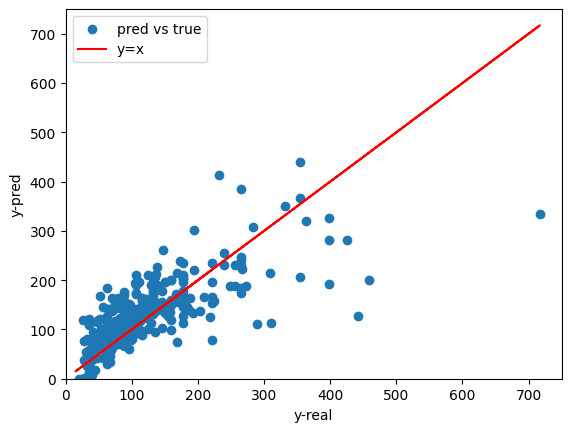

In [255]:
linear_model.fit(X_train, y_train)
linear_train_score = linear_model.score(X_train, y_train)
linear_val_score = linear_model.score(X_val,y_val)
linear_test_score = linear_model.score(X_test,y_test)

print("Training score: ", linear_train_score)
print("Test score: ", linear_test_score)
print("Validation score: ", linear_val_score)

plotPredVsReal(y_test, linear_model.predict(X_test), 750)


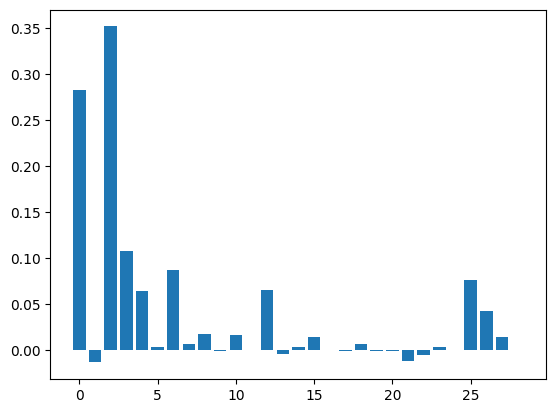

In [256]:
plot_feature_importance(linear_model, X_val, y_val)

In [257]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

Training score: 0.4904941400391126
Test score: 0.5937850299712871
Validation score: 0.481247169684355


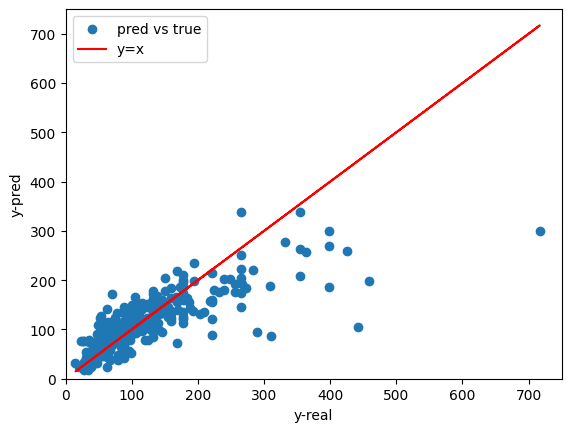

In [258]:
from sklearn.svm import NuSVR
best_score = 0
best_model = NuSVR()
for i in range(20):
    svr_model = NuSVR(C=4*i+1, nu=0.04*i+0.005)
    svr_model.fit(X_train, y_train)
    score = svr_model.score(X_val, y_val)
    if(score >best_score):
        best_score = score
        best_model = svr_model



svr_train_score = best_model.score(X_train, y_train)
svr_test_score = best_model.score(X_test, y_test)
svr_val_score = best_model.score(X_val, y_val)
print("Training score:", svr_train_score)
print("Test score:", svr_test_score)
print("Validation score:", svr_val_score)

plotPredVsReal(y_test, best_model.predict(X_test), 750)


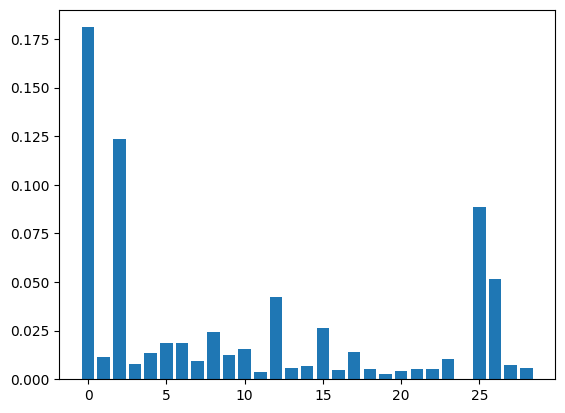

In [259]:
plot_feature_importance(best_model, X_val, y_val)

In [260]:
best_model.score(lX, ly)

-0.05221699772008348

Training score:  0.7212324011307412
Test score:  0.4565676455351696
Validation score:  0.45589825455848165


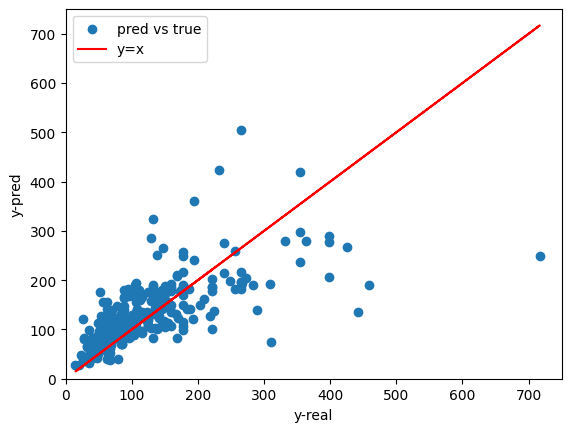

In [261]:
from sklearn.ensemble import RandomForestRegressor
best_score = 0
best_model = RandomForestRegressor()
for i in range(8):
    regr_model = RandomForestRegressor(max_depth=int(i*0.5+4), random_state=0, n_estimators=12*i+20)
    regr_model.fit(X_train, y_train)
    score = regr_model.score(X_val, y_val)
    if(score >best_score):
        best_score = score
        best_model = regr_model



regr_train_score = best_model.score(X_train, y_train)
regr_test_score = best_model.score(X_test, y_test)
regr_val_score = best_model.score(X_val, y_val)

print("Training score: ", regr_train_score)
print("Test score: ", regr_test_score)
print("Validation score: ", regr_val_score)


plotPredVsReal(y_test, best_model.predict(X_test), 750)



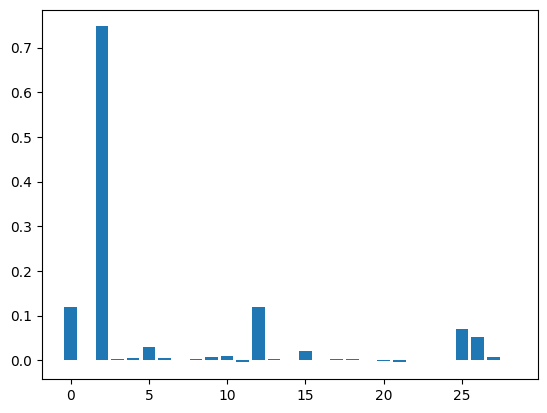

In [262]:
plot_feature_importance(best_model, X_val, y_val)

In [263]:
from sklearn.linear_model import Lasso


lasso_model = Lasso(alpha=6)
lasso_model.fit(X_train, y_train)

lasso_train_score = lasso_model.score(X_train, y_train)
lasso_test_score = lasso_model.score(X_test, y_test)
lasso_val_score = lasso_model.score(X_val, y_val)

print("Training score: ", lasso_train_score)
print("Test score: ", lasso_test_score)
print("Validation score: ", lasso_val_score)


Training score:  0.34310454317971406
Test score:  0.49840817907077073
Validation score:  0.410140519309646


In [264]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="r2",verbose=3
                      )

search.fit(X_train,y_train)

print(search.best_params_)


coefficients = search.best_estimator_.named_steps['model'].coef_

pipeline

importance = np.abs(coefficients)



Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ..................model__alpha=0.1;, score=0.474 total time=   0.1s
[CV 2/5] END ..................model__alpha=0.1;, score=0.272 total time=   0.2s
[CV 3/5] END ..................model__alpha=0.1;, score=0.523 total time=   0.1s
[CV 4/5] END ..................model__alpha=0.1;, score=0.336 total time=   0.1s
[CV 5/5] END ..................model__alpha=0.1;, score=0.430 total time=   0.3s
[CV 1/5] END ..................model__alpha=0.2;, score=0.474 total time=   0.1s
[CV 2/5] END ..................model__alpha=0.2;, score=0.271 total time=   0.0s
[CV 3/5] END ..................model__alpha=0.2;, score=0.521 total time=   0.1s
[CV 4/5] END ..................model__alpha=0.2;, score=0.336 total time=   0.1s
[CV 5/5] END ..................model__alpha=0.2;, score=0.432 total time=   0.1s
[CV 1/5] END ..model__alpha=0.30000000000000004;, score=0.473 total time=   0.1s
[CV 2/5] END ..model__alpha=0.30000000000000004

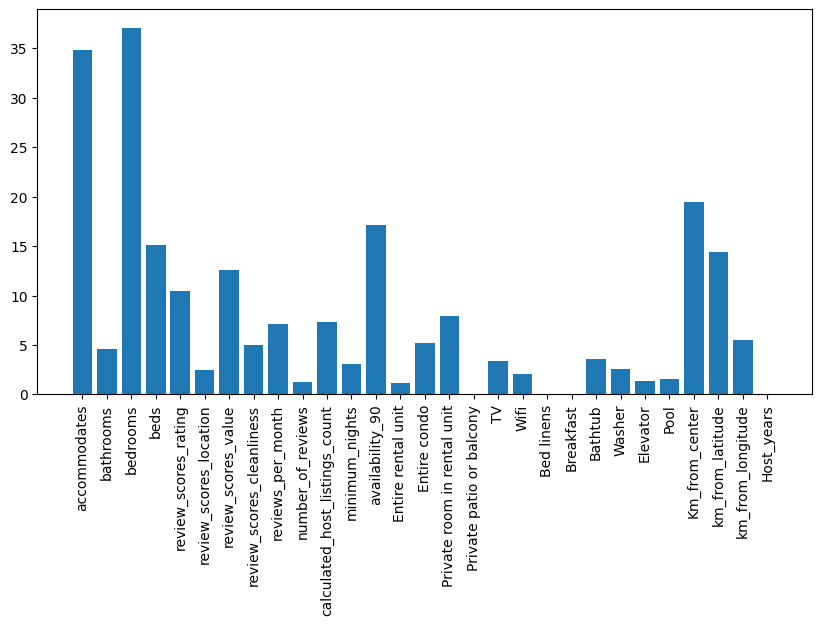

29

In [278]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(importance)), importance)
plt.gca().set(xticks=range(len(importance)), xticklabels = featureNames)
plt.xticks(rotation=90)
plt.show()

len(importance)

[0]	validation_0-rmse:120.38859
[1]	validation_0-rmse:103.49121
[2]	validation_0-rmse:91.56094
[3]	validation_0-rmse:82.48522
[4]	validation_0-rmse:77.01076
[5]	validation_0-rmse:73.20708
[6]	validation_0-rmse:69.83819
[7]	validation_0-rmse:68.06214
[8]	validation_0-rmse:66.93655
[9]	validation_0-rmse:66.29982
[10]	validation_0-rmse:65.70401
[11]	validation_0-rmse:65.20307
[12]	validation_0-rmse:65.20559
[13]	validation_0-rmse:65.01003
[14]	validation_0-rmse:64.25561
[15]	validation_0-rmse:64.02178
[16]	validation_0-rmse:63.77544
[17]	validation_0-rmse:63.64436
[18]	validation_0-rmse:63.28235
[19]	validation_0-rmse:63.04456
[20]	validation_0-rmse:63.40296
[21]	validation_0-rmse:63.15799
[22]	validation_0-rmse:63.49485
[23]	validation_0-rmse:63.56452
[24]	validation_0-rmse:63.26025
[25]	validation_0-rmse:63.22001
[26]	validation_0-rmse:63.08746
[27]	validation_0-rmse:63.20911
[28]	validation_0-rmse:63.39298
[29]	validation_0-rmse:63.09774
[30]	validation_0-rmse:62.93510
[31]	validation_

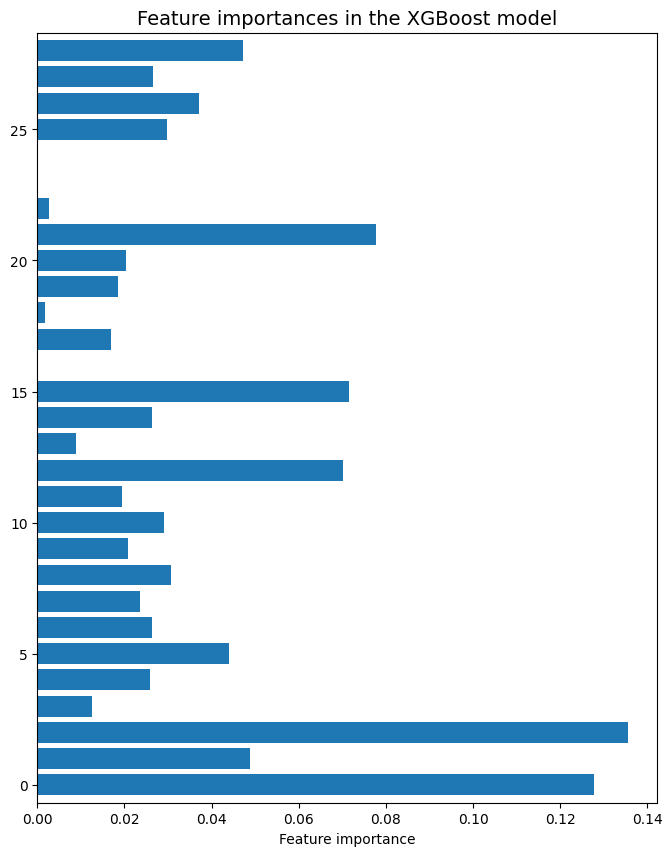

In [266]:
import math
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import xgboost as xgb



X_train = pd.DataFrame(X_train, dtype='float')
X_test = pd.DataFrame(X_test, dtype='float')
X_val = pd.DataFrame(X_val, dtype='float')


y_train = pd.DataFrame(y_train, dtype='float')
y_test = pd.DataFrame(y_test, dtype='float')
y_val = pd.DataFrame(y_val, dtype='float')

# Fitting the model
# learning_rate=0.3, gamma =0.3 ,max_depth=3, n_estimators=17,


eval_set = [(X_val, y_val)]

xgb_reg = xgb.XGBRegressor(learning_rate=0.2, max_depth=3, subsample=0.9, colsample_bytree = 0.7, n_estimators=100, eval_metric="rmse")
# , verbose=True
xgb_reg.fit(X_train, y_train, eval_set=eval_set)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_val)
test_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results

print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test, test_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_val, val_preds_xgb_reg),4))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,10))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()



In [267]:
# import math
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.losses import MeanSquaredLogarithmicError
# from sklearn.metrics import r2_score

# X_train = pd.DataFrame(X_train)
# X_test = pd.DataFrame(X_test)
# X_val = pd.DataFrame(X_val)
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)
# y_val = pd.DataFrame(y_val)

# def scale_datasets(x_train, x_test, x_val):
#     """
#     Standard Scale test and train data
#     Z - Score normalization
#     """
#     standard_scaler = StandardScaler()
#     x_train_scaled = pd.DataFrame(
#         standard_scaler.fit_transform(x_train),
#         columns=x_train.columns
#     )
#     x_test_scaled = pd.DataFrame(
#         standard_scaler.transform(x_test),
#         columns = x_test.columns
#     )
#     x_val_scaled = pd.DataFrame(
#         standard_scaler.transform(x_val),
#         columns = x_val.columns
#     )
#     return x_train_scaled, x_test_scaled, x_val_scaled
# x_train_scaled, x_test_scaled, x_val_scaled = scale_datasets(X_train, X_test, X_val)

In [268]:
# hidden_units1 = 200
# hidden_units2 = 520
# hidden_units3 = 256
# learning_rate = 5e-5
# # Creating model using the Sequential in tensorflow
# def build_model_using_sequential():
#   model = Sequential([
#     Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
#     Dense(1, kernel_initializer='normal', activation='linear')
#   ])
#   return model
# # build the model
# model = build_model_using_sequential()

In [1]:
# # loss function
# msle = MeanSquaredLogarithmicError()
# model.compile(
#     loss=msle, 
#     optimizer=Adam(learning_rate=learning_rate), 
#     metrics=[msle]
# )
# # train the model
# history = model.fit(
#     x_train_scaled.values, 
#     np.asarray(y_train.values).astype('float32'), 
#     epochs=110, 
#     batch_size=16,
#     validation_split=0.2
# )

In [2]:
# def plot_history(history, key):
#   plt.plot(history.history[key])
#   plt.plot(history.history['val_'+key])
#   plt.xlabel("Epochs")
#   plt.ylabel(key)
#   plt.legend([key, 'val_'+key])
#   plt.show()
# # Plot the history
# plot_history(history, 'mean_squared_logarithmic_error')

# # X_test['prediction'] = model.predict(x_test_scaled)

# print("Training score:", r2_score(y_train, model.predict(x_train_scaled)))
# print("Test score:", r2_score(y_test, model.predict(x_test_scaled)))
# print("Validation score:", r2_score(y_val, model.predict(x_val_scaled)))

# # scale_datasets
# # print("Stockholm score:", r2_score(y_val, model.predict(x_val_scaled)))
# # print("London score:", r2_score(y_val, model.predict(x_val_scaled)))
# # print("Berlin score:", r2_score(y_val, model.predict(x_val_scaled)))


In [ ]:
# Neural network on copenhagen
# cx = np.concatenate((cX,lX), axis=0)
# cY = np.concatenate((cy,ly), axis=0)
cx = np.asarray(cX).astype('float32')
cY = np.asarray(cy).astype('float32')



cX_train, cX_testval, cy_train, cy_testval = train_test_split(cx, cY, test_size=0.20, random_state=4)
cX_test, cX_val, cy_test, cy_val = train_test_split(cX_testval, cy_testval, test_size=0.5, random_state=4)

print(cX_train.shape, cX_test.shape, cX_val.shape)



In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#normalize our data
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
cx_train_sc = X_scaler.fit_transform(cX_train)
cx_val_sc = X_scaler.transform(cX_val)
cx_test_sc = X_scaler.transform(cX_test)

cx_train_sc.shape

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
#adagrad = 0.02, sgd = 
lr = 0.06
p = 0.2
model = Sequential()
#found 16 to be optimal
model.add(Dense(units=16, input_dim=29, kernel_initializer='normal', activation='relu'))
# p = 0.2 optimal
model.add(Dropout(p))
model.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(p))
# model.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
print(model.summary())
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_msle'
                        , patience = 3
                        , verbose = 1
                        , mode = 'auto'
                        , min_delta = 0.001)

num_epochs = 100

#larger --> increase stockholm score
#smaller --> increase copen score
# too large / too small, predictions converge to same value
b_size = 32
#optimizers: adam, sgd, 
model.compile(loss="msle", optimizer=SGD(learning_rate=lr), metrics = ['msle'])

history = model.fit(cx_train_sc, cy_train,
                   batch_size = b_size,
                   epochs = num_epochs,
                   verbose = 1,
                   validation_data=(cx_val_sc, cy_val),
                   callbacks = [callback])

# def getAccuracy(x,y):
#     predictions = model.predict(x)
#     #APE (absolute percent error)
#     APE = 100*(abs(y-predictions)/y)
#     accuracy = 100-np.mean(APE)
#     return accuracy


# accuracy = getAccuracy(cx_test_sc, cy_test)
# print('Accuracy of model on test set: ', accuracy)

# sx, sY = np.asarray(sX).astype('float32'), np.asarray(sy).astype('float32')
# acc_stock = getAccuracy(sx,sY)
# print('Model evaluated on Stockholm: ', acc_stock)

In [ ]:
c_pred = model.predict(cx_test_sc)
print("Copenhagen test set")
plotPredVsReal(cy_test, c_pred, 750)
print("Test r2:", round(r2_score(cy_test, c_pred),4))

In [ ]:
sx, sY = np.asarray(sX).astype('float32'), np.asarray(sy).astype('float32')
sx_sc = X_scaler.transform(sx)
s_pred = model.predict(sx_sc)
print("Stockholm evaluated on copenhagen test set")
plotPredVsReal(sY, s_pred, 750)
print("Test r2:", round(r2_score(sY, s_pred),4))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['msle'])
plt.plot(history.history['val_msle'])
plt.ylabel('msle')
plt.xlabel('epoch')
plt.title('Neural Network')
plt.legend(['train', 'validation'])
plt.show()